# Image Classification of ATLAS Calorimeter Topo-Clusters (Jan)

## This is a stripped-down version of Max's re-write, so I have removed *some* functionality.

In [1]:
# If loadModel, we will load a pre-trained model. Otherwise we will train a new model.
loadModel = True

# If saveModel, we will save the model in memory. Redundant if loadModel == True.
saveModel = False

Quick Navigation:
- [Simple feed-forward Neural Network](#Simple-feed-forward-Neural-Network.)
- [ROC Curve Scans](#ROC-Curve-Scans)
- [Combination Network](#Combination-Network)
- [Convolutional Neural Network](#Convolutional-Neural-Network)
- [Correlation Plots](#Correlation-Plots)

In [2]:
#import libraries and some constants
import os, sys, json, pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, TwoSlopeNorm
import pandas as pd
import ROOT as rt # I will use this for some plotting
import uproot as ur

path_prefix = os.getcwd() + '/../'
plotpath = path_prefix+'classifier/Plots/'
modelpath = path_prefix+'classifier/Models/'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

Welcome to JupyROOT 6.22/02


In [29]:
# fancy display names for each pion type
pi_latex = {
    'pi0': '\(\pi^{0}\)',
    'piplus': '\(\pi^{+}\)',
    'piminus': '\(\pi^{-}\)',
}

pi_latex_mpl = {
    'pi0': '$\pi^{0}$',
    'piplus': '$\pi^{+}$'
}

Now let's import our resolution utilities. These take care of some plotting, using `matplotlib` and the `atlas_mpl_style` package.

In [4]:
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
from util import qol_util as qu

In [5]:
# Plotting settings

# plotting mode
mode = 'dark'

# xkcd -- turn this on for fun-looking (but marginally less useful) plots
use_xkcd = False
if(use_xkcd):
    mode = 'light'
    plt.xkcd(scale=.75,length=100,randomness=1)
    
# plotting style -- manages our color palette and object colors
plotstyle = qu.PlotStyle(mode)
    
# some matplotlib-specific stuff
params = {'legend.fontsize': 13,
          'axes.labelsize': 18}
plt.rcParams.update(params)

Now, we will import our data from the `ROOT` files into a `pandas` DataFrame. The first cell takes care of scalars, and the second takes care of vectors.

In [6]:
# import pi+- vs. pi0 images
source = 'pion' # also try 'jet'

if(source == 'pion'):
    inputpath = path_prefix+'data/pion/'
    rootfiles = ["pi0", "piplus", "piminus"]
    branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi', 'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min', 'cluster_cell_dR_max', 'cluster_cell_dEta_min', 'cluster_cell_dEta_max', 'cluster_cell_dPhi_min', 'cluster_cell_dPhi_max', 'cluster_cell_centerCellEta', 'cluster_cell_centerCellPhi', 'cluster_cell_centerCellLayer', 'cluster_cellE_norm']
elif(source == 'jet'):
    inputpath = path_prefix+'jets/training/'
    rootfiles = ["pi0", "piplus"]
    branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi', 'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_ENG_CALIB_TOT']
else:
    assert(False)

trees = {
    rfile : ur.open(inputpath+rfile+".root")['ClusterTree']
    for rfile in rootfiles
}
pdata = {
    ifile : itree.pandas.df(branches, flatten=False)
    for ifile, itree in trees.items()
}

total = 0
for key in rootfiles:
    total += len(pdata[key])

for key in rootfiles:
    n = len(pdata[key])
    print("Number of {a:<7} events: {b:>10}\t({c:.1f}%)".format(a=key, b = n, c = 100. * n / total))
print("Total: {}".format(total))

Number of pi0     events:     264167	(23.2%)
Number of piplus  events:     436949	(38.4%)
Number of piminus events:     436802	(38.4%)
Total: 1137918


The number of events for each category may be quite different -- ultimately we want to train our classifier on a "balanced" dataset, where we have equal numbers of entries from each category.

We're training our network to classify between $\pi^\pm$ and $\pi^0$ events. Thus, we should ultimately merge our $\pi^+$ and $\pi^-$ data.

Thus, we will first generate selected indices for all categories, such that the total number of events from each category is equal, and *then* we will merge things.

Note that as we're dealing with DataFrames (`pdata`) and uproot trees (`trees`, whose contents get loaded into `pcells`), we have to be careful that when we merge data, we do it the same way for both sets of objects. Otherwise we might scramble our $\pi^\pm$ data -- which will matter *if* we ever want to use inputs beyond just the images (from `trees`) as network input.

In [7]:
n_indices = {}
n_max = int(np.min(np.array([len(pdata[key]) for key in trees.keys()])))
rng = np.random.default_rng()

# If we have a piminus key, assume the dataset are piplus, piminus, pi0
if('piminus' in trees.keys()):
    n_indices['piplus']  = int(np.ceil((n_max / 2)))
    n_indices['piminus'] = int(np.floor((n_max / 2)))
    n_indices['pi0']     = n_max
    
# Otherwise, assume we already have piplus (or piplus + piminus) and pi0, no merging needed
else: n_indices = {key:n_max for key in trees.keys}
indices = {key:rng.choice(len(pdata[key]), n_indices[key], replace=False) for key in trees.keys()}

# Make a boolean array version of our indices, since pandas is weird and doesn't handle non-bool indices?
bool_indices = {}
for key in pdata.keys():
    bool_indices[key] = np.full(len(pdata[key]), False)
    bool_indices[key][indices[key]] = True

# Apply the (bool) indices to pdata
for key in trees.keys():
    pdata[key] = pdata[key][bool_indices[key]]


# prepare pcells -- immediately apply our selected indices
pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, indices = indices[ifile])
        for layer in layers
    }
    for ifile, itree in trees.items()
}

In [8]:
# Now with the data extracted from the trees into pcells, we merge pdata and pcells as needed.
# Note the order in which we concatenate things: piplus -> piplus + piminus.
if('piminus' in trees.keys()):
    print('Merging piplus and piminus.')
    
    # merge pdata
    pdata['piplus'] = pdata['piplus'].append(pdata['piminus'])
    del pdata['piminus']
    
    # merge contents of pcells
    for layer in layers:
        pcells['piplus'][layer] = np.row_stack((pcells['piplus'][layer],pcells['piminus'][layer]))
    del pcells['piminus']

Merging piplus and piminus.


We'll train the network on $\pi^+$ and $\pi^0$ events.

In [9]:
from keras.utils import np_utils
training_dataset = ['pi0','piplus']

# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
for p_index, plabel in enumerate(training_dataset):
    mu.splitFrameTVT(pdata[plabel],trainfrac=0.7)
    pdata[plabel]['label'] = p_index

# merge pi0 and pi+ events
pdata_merged = pd.concat([pdata[ptype] for ptype in training_dataset])
pcells_merged = {
    layer : np.concatenate([pcells[ptype][layer]
                            for ptype in training_dataset])
    for layer in layers
}
plabels = np_utils.to_categorical(pdata_merged['label'],len(training_dataset))

### Plot a few example images.

These are the images that we will use to train our network (together with a few other variables).

<Figure size 432x288 with 0 Axes>

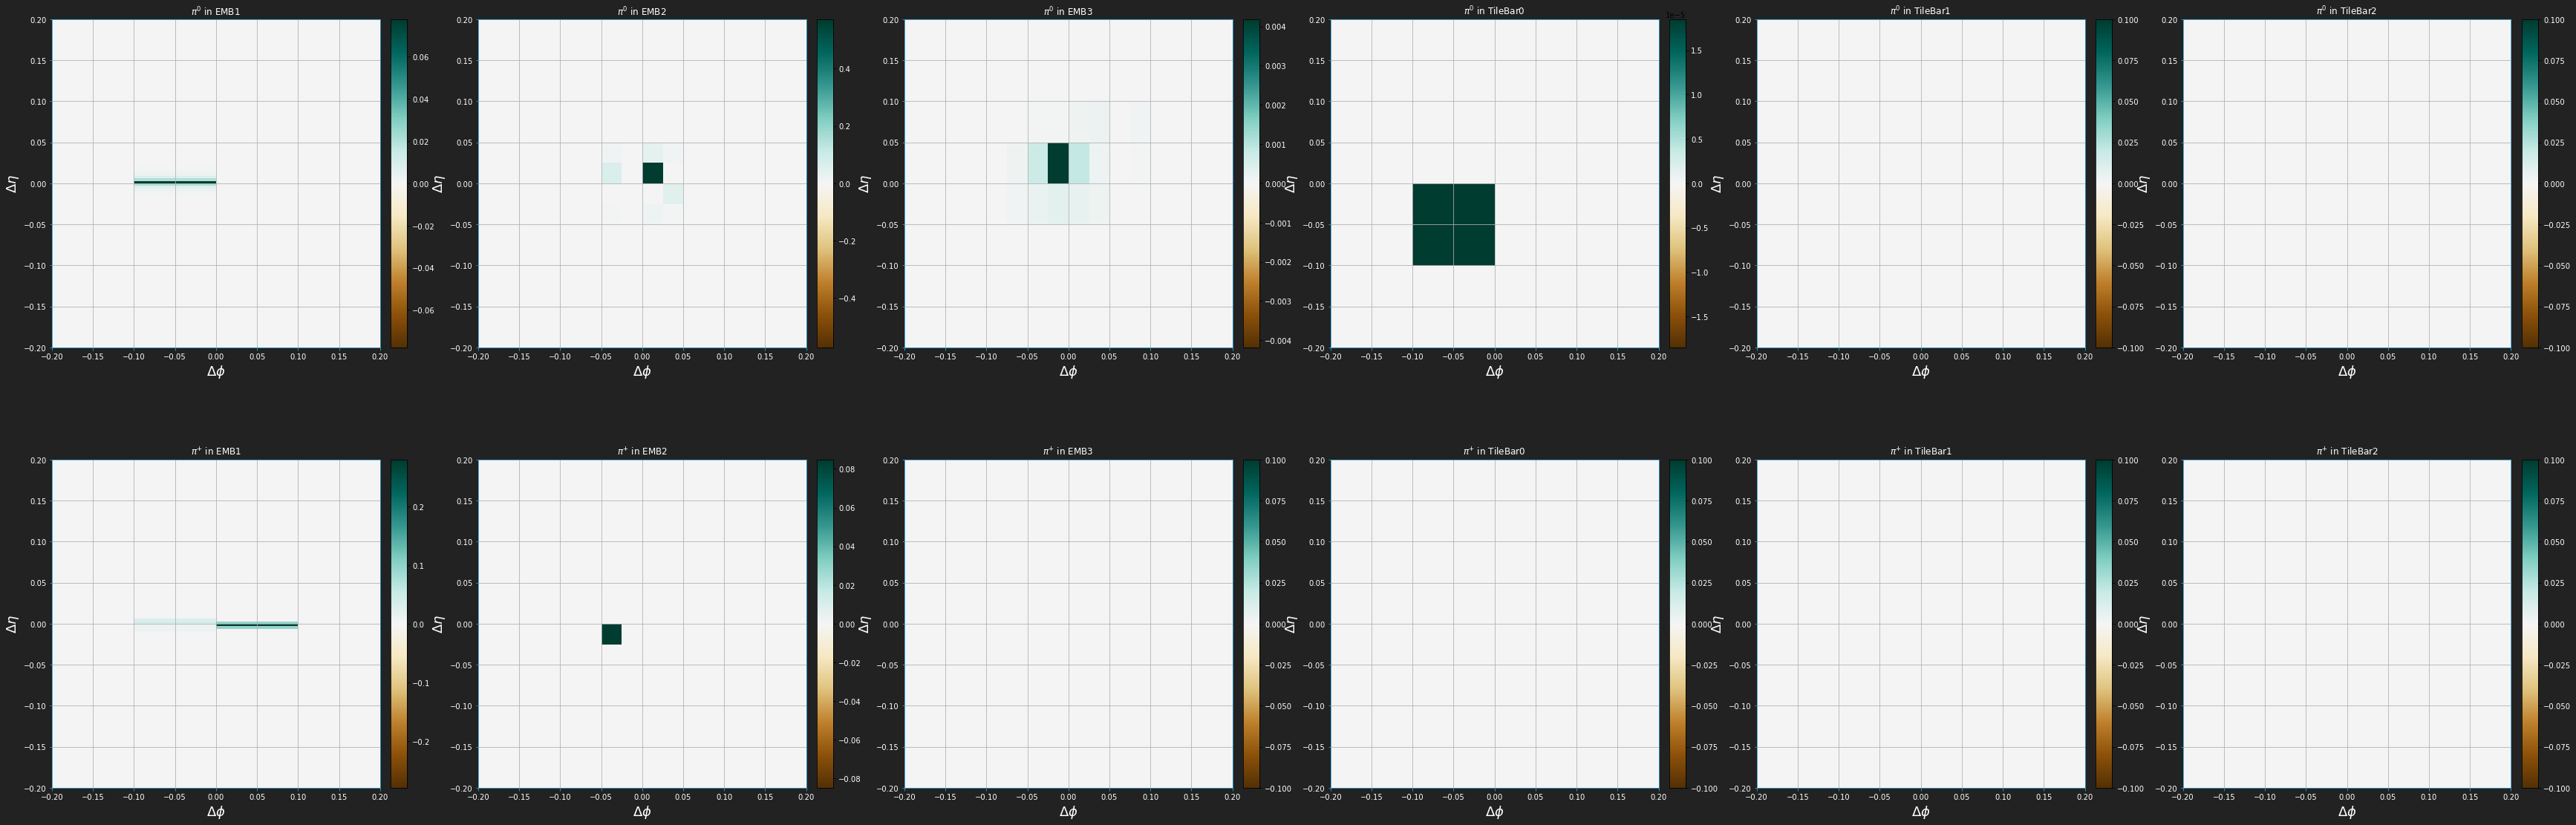

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import copy

# specify which cluster to plot
cluster = 100

# make the plot
plt.cla(); plt.clf()

fig, ax = plt.subplots(2,6,figsize=(60,20))
fig.patch.set_facecolor(plotstyle.canv_plt)

i = 0
for ptype, pcell in pcells.items():
    for layer in layers:
        axis = ax.flatten()[i]
        
        image = pcell[layer][cluster].reshape(cell_shapes[layer])
        vmin, vmax = np.min(image), np.max(image)
        vmax = np.maximum(np.abs(vmin),np.abs(vmax))
        vmin = -vmax
        
        if(vmax == 0. and vmin == 0.):
            vmax = 0.1
            vmin = -vmax
        
        norm = TwoSlopeNorm(vmin=vmin,vcenter=vcenter,vmax=vmax)
        cmap = plt.get_cmap('BrBG')
        
        im = axis.imshow(
            pcell[layer][cluster].reshape(cell_shapes[layer]), 
            extent=[-0.2, 0.2, -0.2, 0.2],
            cmap=cmap, 
            origin='lower', 
            interpolation='nearest',
            norm=norm
        )
                
        #axis.colorbar()
        axis.set_title('{a} in {b}'.format(a=pi_latex_mpl[ptype],b=layer))
        axis.set_xlabel("$\Delta\phi$")
        axis.set_ylabel("$\Delta\eta$")
        
        plotstyle.SetStylePlt(axis)
        divider = make_axes_locatable(axis)
        cax = divider.append_axes('right', size='5%', pad=0.2)
        cb = fig.colorbar(im, cax=cax, orientation='vertical')
        plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=plotstyle.text_plt)
        
        i += 1
        
# show the plots
plt.savefig(plotpath+'plots_pi0_plus_minus.png',transparent=True,facecolor=plotstyle.canv_plt)
plt.show()

### Plot a few histograms.

These are a bit uglier than the `matplotlib` ones Max made, but it's perhaps even easier to see any differences between $\pi^\pm$ and $\pi^0$.

Info in <TCanvas::Print>: pdf file /local/home/jano/ml4pions/LCStudies/classifier/../classifier/Plots/hist_pi0_plus_minus.pdf has been created


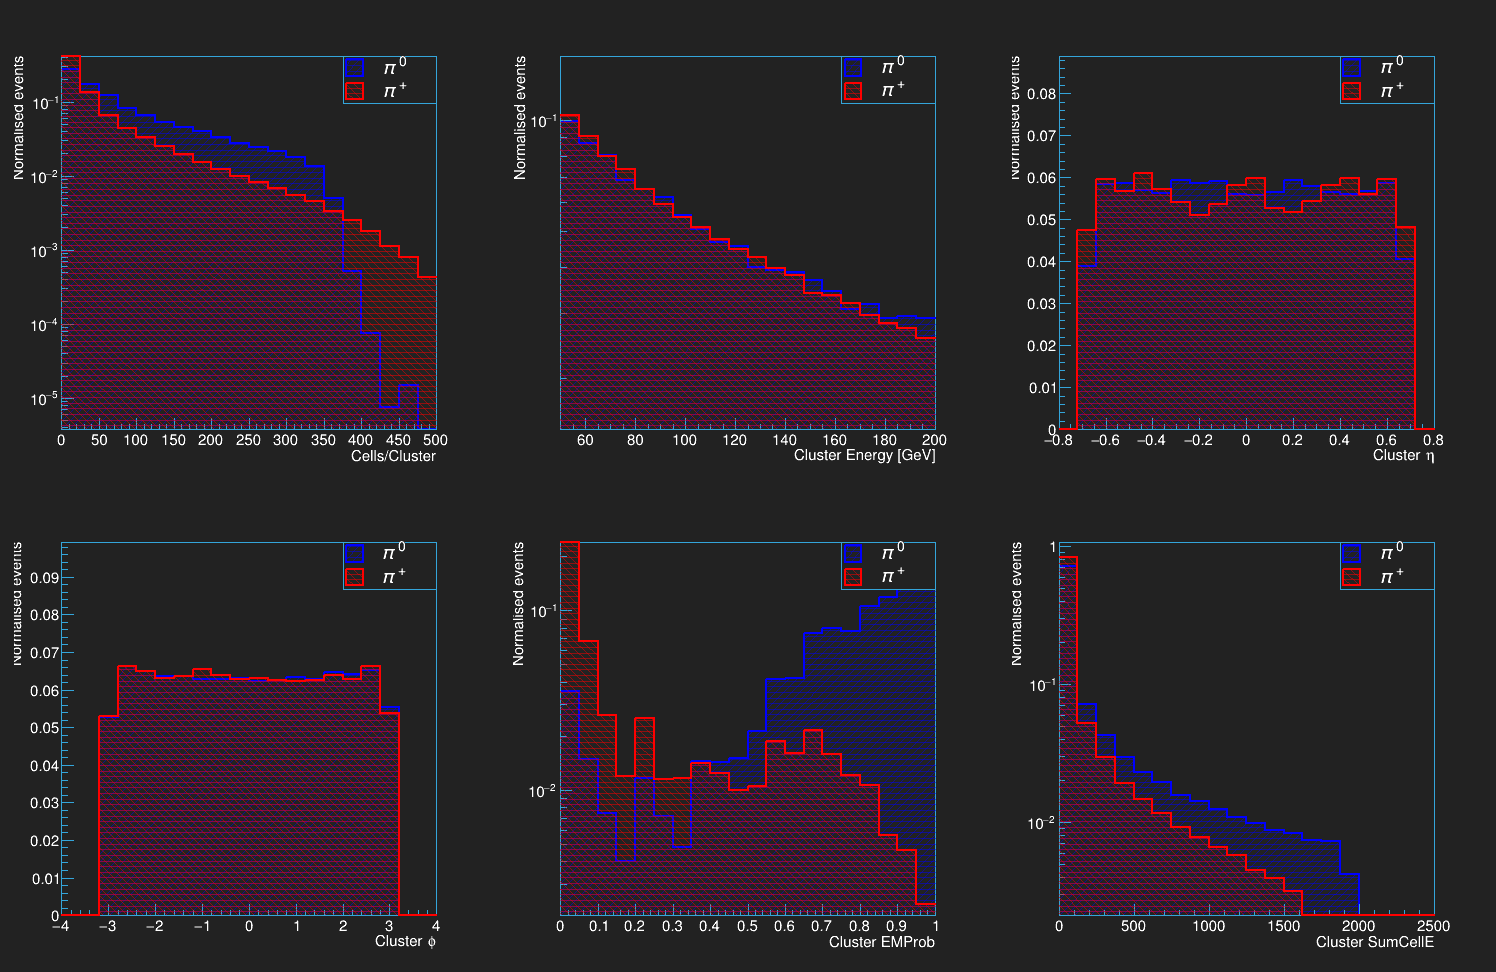

In [35]:
rt.gStyle.SetOptStat(0)

plotstyle.SetStyle()

# For storing histograms and legends, to prevent overwriting. (TODO: Probably better ways to do this in PyROOT)
histos = []
legends = []

qtys = ['cluster_nCells', 'clusterE', 'clusterEta', 'clusterPhi', 'cluster_EM_PROBABILITY', 'cluster_sumCellE']
qty_labels = ['Cells/Cluster', 'Cluster Energy [GeV]', 'Cluster #eta', 'Cluster #phi', 'Cluster EMProb', 'Cluster SumCellE']
qty_ranges = [(0,500), (50,200), (-0.8,0.8), (-4.,4.), (0.,1.), (0.,2500.)]

if(source == 'jet'):
    qtys = ['cluster_nCells', 'clusterE', 'clusterEta', 'clusterPhi']
    qty_labels = ['Cells/Cluster', 'Cluster Energy [GeV]', 'Cluster #eta', 'Cluster #phi']
    qty_ranges = [(0,300), (0,100), (-0.8,0.8), (-4.,4.)]

# Set up a canvas.
plot_size = 500
nx = int(np.ceil(len(qtys) / 2))
ny = 2
n_pad = nx * ny
canvas = rt.TCanvas('cluster_hists','c1',plot_size * nx,plot_size * ny)
canvas.Divide(nx,ny)

colors = {'piplus':rt.kRed,'pi0':rt.kBlue}
styles = {'piplus':3440, 'pi0':3404}

n_bins=20
for i, (qty, label, rng) in enumerate(zip(qtys, qty_labels, qty_ranges)):
    canvas.cd(i+1)
    leg = rt.TLegend(0.7,0.8,0.9,0.9)
    for ptype, p in pdata.items():
        hist = rt.TH1F('h_'+str(ptype)+'_'+str(qty),'',n_bins,rng[0],rng[1])
        for entry in p[qty]: hist.Fill(entry)
        integral = hist.Integral()
        if(integral != 0): hist.Scale(1./hist.Integral())
        hist.SetLineColor(colors[ptype])
        hist.SetLineWidth(2)
        hist.SetFillColorAlpha(colors[ptype],0.5)
        hist.SetFillStyle(styles[ptype])
        hist.Draw('HIST SAME')
        hist.GetXaxis().SetTitle(label)
        hist.GetYaxis().SetTitle('Normalised events')
        hist.SetMaximum(1.5 * hist.GetMaximum())
        leg.AddEntry(hist,pi_latex[ptype],'f')
        leg.Draw()
        histos.append(hist)
        legends.append(leg)
    if(qty in ['cluster_nCells','clusterE', 'cluster_EM_PROBABILITY', 'cluster_sumCellE']): rt.gPad.SetLogy()
canvas.Draw()
canvas.SaveAs(plotpath+'hist_pi0_plus_minus.pdf')

## Simple feed-forward Neural Network.
<div style="text-align: right"> <a href="#Image-Classification-of-ATLAS-Calorimeter-Topo-Clusters-Rewrite">Top</a> </div>

First, we're going to train a simple, feed-foward neural network. This will be our "baseline network".

Let's import `TensorFlow`, and get our GPU ready. We assume that there's only one available, otherwise you can modify the list below.

In [36]:
ngpu = 1
gpu_list = ["/gpu:"+str(i) for i in range(ngpu)]
#gpu_list = ["/gpu:0"] #["/gpu:0","/gpu:1","/gpu:2","/gpu:3"]

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disable some of the tensorflow info printouts, only display errors
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [37]:
models = {}
model_history = {}
model_scores = {}
model_performance = {}

In [38]:
from models import baseline_nn_model

lr = 5e-5
dropout = 0.2 # < 0 -> no dropout
model = baseline_nn_model(strategy, lr=lr, dropout=dropout)

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts

flat_dir = modelpath + 'flat' # directory for loading/saving flat models

In [39]:
if (not loadModel):
    
    # initialize the models
    for layer in layers:
        npix = cell_shapes[layer][0]*cell_shapes[layer][1]
        models[layer] = model(npix)
        if(verbose > 1): models[layer].summary()
            
    # prepare the save directory
    if(saveModel):
        try: os.makedirs(rn_dir)
        except: pass
        
    
    # train the models -- and save each model if requested
    for layer in layers:
        print('On layer ' + layer + '.')
    
        # train+validate model
        model_history[layer] = models[layer].fit(
            pcells_merged[layer][pdata_merged.train], plabels[pdata_merged.train],
            validation_data = (
                pcells_merged[layer][pdata_merged.val], plabels[pdata_merged.val]
            ),
            epochs = nepochs, batch_size = batch_size, verbose = verbose,
        )
    
        model_history[layer] = model_history[layer].history
    
        # get overall performance metric
        model_performance[layer] = models[layer].evaluate(
            pcells_merged[layer][pdata_merged.test], plabels[pdata_merged.test],
            verbose = 0,
        )
    
        # get network scores for the dataset
        model_scores[layer] = models[layer].predict(
            pcells_merged[layer]
        )
        print('Finished layer ' + layer + '.')
        
        if(saveModel):
            print('Saving layer ' + layer + '.')
            models[layer].save(flat_dir + '/' +'model_' + layer + '_flat_do20.h5')
            
            with open(flat_dir + '/' + 'model_' + layer + '_flat_do20.history','wb') as model_history_file:
                pickle.dump(model_history[layer], model_history_file)

# if not training, load an existing model
else:
    for layer in layers:
        print('Loading ' + layer)
        models[layer] = tf.keras.models.load_model(flat_dir + '/'+'model_' + layer + '_flat_do20.h5')
    
        # load history object
        with open(flat_dir + '/' + 'model_' + layer + '_flat_do20.history','rb') as model_history_file:
            model_history[layer] = pickle.load(model_history_file)
    
        # recalculate network scores for the dataset
        model_scores[layer] = models[layer].predict(
            pcells_merged[layer]
        )    

Loading EMB1
Loading EMB2
Loading EMB3
Loading TileBar0
Loading TileBar1
Loading TileBar2


Let's plot model accuracy and loss as a function of training epoch, for each layer.

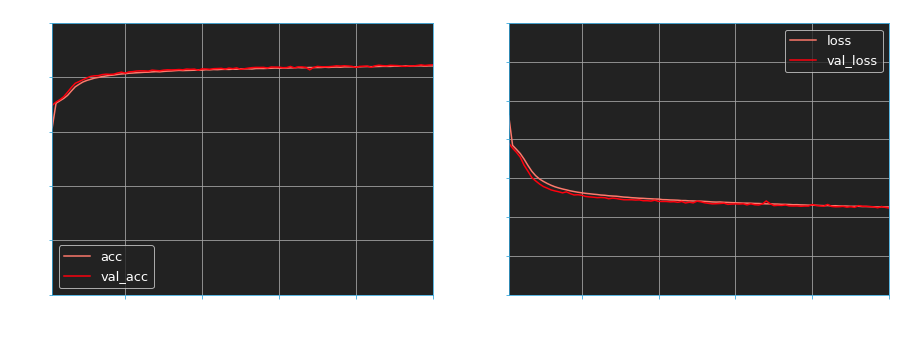

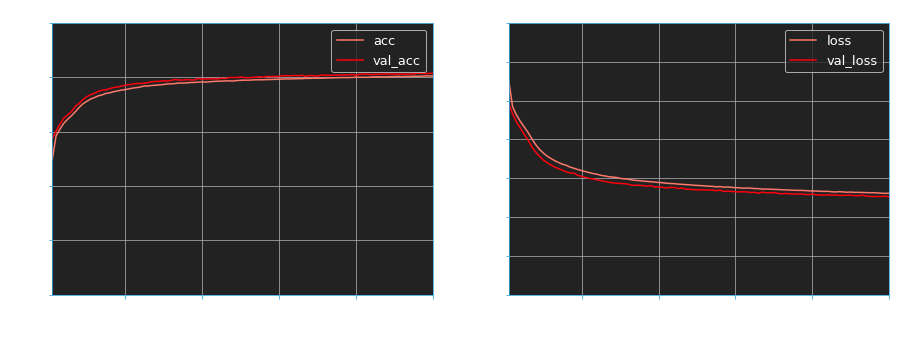

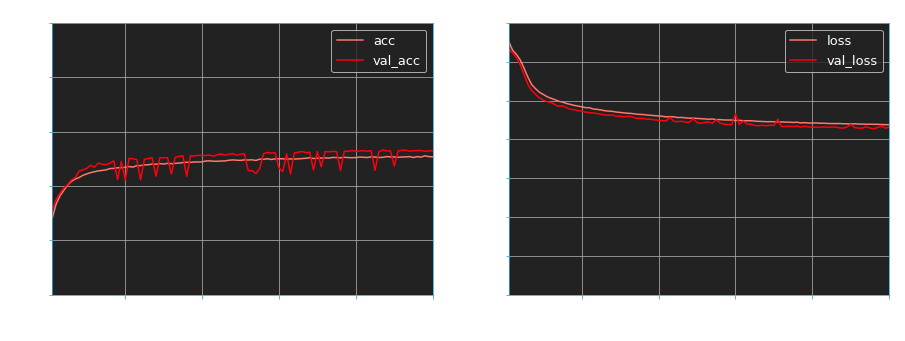

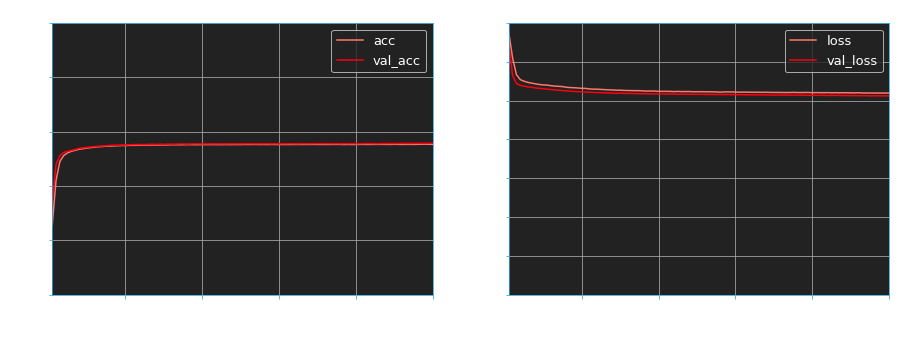

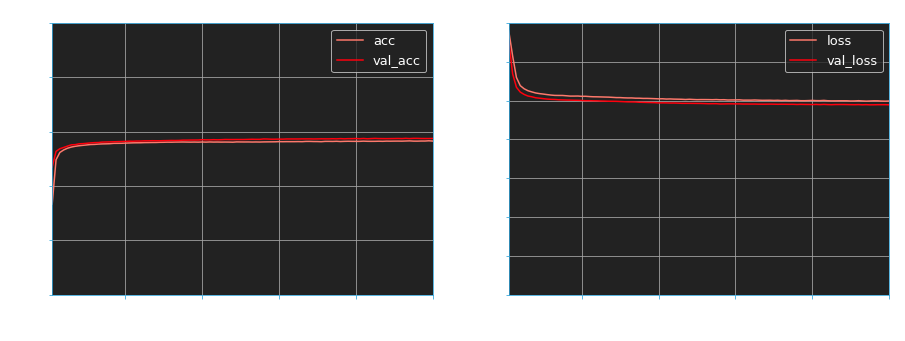

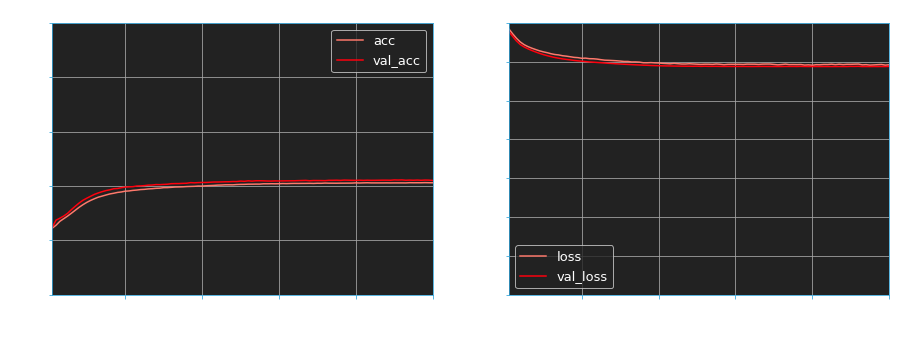

In [40]:
epochs = np.arange(nepochs) + 1
for layer in layers:    
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    keys = ['acc','val_acc']
    lines = [model_history[layer][key] for key in keys]
    pu.multiplot_common(ax[0], epochs,lines, keys, y_min = 0.5, y_max = 1., xlabel = 'Epoch', ylabel = 'Accuracy', title='Model accuracy for {}'.format(layer), ps=plotstyle)
    
    keys = ['loss','val_loss']
    lines = [model_history[layer][key] for key in keys]
    pu.multiplot_common(ax[1], epochs,lines, keys, y_max = .7, xlabel = 'Epoch', ylabel = 'Accuracy', title='Model accuracy for {}'.format(layer), ps=plotstyle)
    
    # add grids
    for axis in ax.flatten():
        axis.grid(True,color=plotstyle.grid_plt)

    qu.SaveSubplots(fig, ax, ['accuracy_{}'.format(layer), 'loss_{}'.format(layer)], savedir=plotpath)
    plt.show()

Now let's look at ROC curves.

In [41]:
from sklearn.metrics import roc_curve, auc

roc_fpr = {}
roc_tpr = {}
roc_thresh = {}
roc_auc = {}

for layer in layers:
    roc_fpr[layer], roc_tpr[layer], roc_thresh[layer] = roc_curve(
        plabels[pdata_merged.test][:,1],
        model_scores[layer][pdata_merged.test,1],
        drop_intermediate=False,
    )
    roc_auc[layer] = auc(roc_fpr[layer], roc_tpr[layer])
    print('Area under curve for ' + layer + ': ' + str(roc_auc[layer]))

Area under curve for EMB1: 0.9603937530362991
Area under curve for EMB2: 0.9535162172994972
Area under curve for EMB3: 0.8542787730138843
Area under curve for TileBar0: 0.7753086191784527
Area under curve for TileBar1: 0.719437464320582
Area under curve for TileBar2: 0.6329873182751182


Let's get the area under the curve for the old method.

In [42]:
lc_fpr, lc_tpr, lc_thresh = roc_curve(
    plabels[pdata_merged.test][:,1],
    1-pdata_merged["cluster_EM_PROBABILITY"][pdata_merged.test],
)
lc_auc = auc(lc_fpr, lc_tpr)
print("Area under curve for cluster_EM_PROB: " + str(lc_auc))

Area under curve for cluster_EM_PROB: 0.9380688936298779


Now let's compare one of our new, simple networks, against the old method `EMProb`.

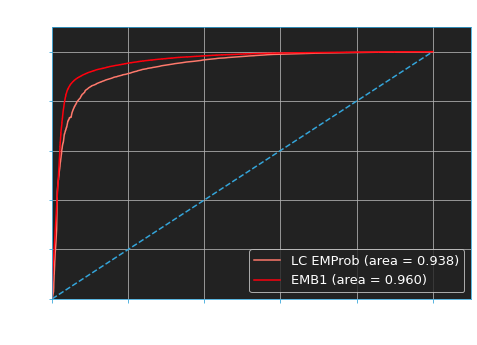

In [43]:
comp_method = 'EMB1'
fig, ax = plt.subplots(1,1,figsize=(7.5,5))
pu.roc_plot(ax, 
            xlist=[lc_fpr,roc_fpr[comp_method]], 
            ylist=[lc_tpr,roc_tpr[comp_method]],
            labels=['LC EMProb (area = {:.3f})'.format(lc_auc),comp_method +' (area = {:.3f})'.format(roc_auc[comp_method])],
            title='Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$',
            ps=plotstyle
            )
plt.savefig(plotpath + 'roc_lc_only.png', transparent=True, facecolor=plotstyle.canv_plt)
plt.show()

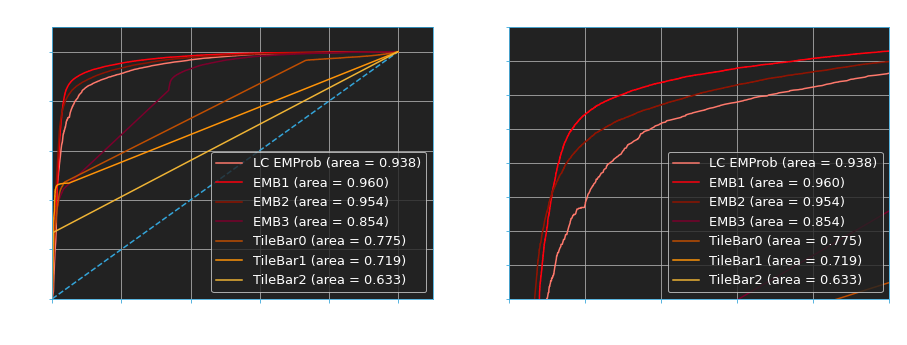

In [47]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

xlist = [lc_fpr]
ylist = [lc_tpr]
labels = ['LC EMProb (area = {:.3f})'.format(lc_auc)]
for layer in layers:
    xlist.append(roc_fpr[layer])
    ylist.append(roc_tpr[layer])
    labels.append('{} (area = {:.3f})'.format(layer, roc_auc[layer]))
title = 'Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$'

pu.roc_plot(ax[0], 
            xlist=xlist, 
            ylist=ylist,
            labels=labels,
            title=title,
            ps=plotstyle
            )

title = 'ROC curve (zoomed in at top left)'
pu.roc_plot(ax[1], 
            xlist=xlist, 
            ylist=ylist,
            x_min=0. , x_max=0.25,
            y_min=0.6, y_max=1.,
            labels=labels,
            title=title,
            ps=plotstyle
            )

qu.SaveSubplots(fig, ax, ['roc_layers', 'roc_zoom_layers'], savedir=plotpath)
plt.show()

## ROC Curve Scans
<div style="text-align: right"> <a href="#Image-Classification-of-ATLAS-Calorimeter-Topo-Clusters-Rewrite">Top</a> </div>

In [ ]:
# a convenience class for creating ROC curve scans
display_digits=2
class roc_var:
    def __init__(self,
                 name, # name of variable as it appears in the root file
                 bins, # endpoints of bins as a list
                 df,   # dataframe to construct subsets from
                 latex='', # optional latex to display variable name with
                 vlist=None, # optional list to append class instance to
                ):
        self.name = name
        self.bins = bins
        
        if(latex == ''): self.latex = name
        else:            self.latex = latex
        
        self.selections = []
        self.labels = []
        for i, point in enumerate(self.bins):
            if(i == 0):
                self.selections.append( df[name]<point )
                self.labels.append(self.latex+'<'+str(round(point,display_digits)))
            else:
                self.selections.append( (df[name]>self.bins[i-1]) & (df[name]<self.bins[i]) )
                self.labels.append(str(round(self.bins[i-1],display_digits))+'<'+self.latex+'<'+str(round(point,display_digits)))
                if(i == len(bins)-1):
                    self.selections.append( df[name]>point )
                    self.labels.append(self.latex+'>'+str(round(point,display_digits)))
        
        if(vlist != None):
            vlist.append(self)

In [ ]:
def roc_scan(varlist,scan_targets,labels):
    '''
    Creates a set of ROC curve plots by scanning over the specified variables.
    One set is created for each target (neural net score dataset).
    
    varlist: a list of roc_var instances to scan over
    scan_targets: a list of neural net score datasets to use
    labels: a list of target names (strings); must be the same length as scan_targets
    '''
    for target, target_label in zip(scan_targets,labels):
        for v in varlist:
            # prepare matplotlib figure
            plt.cla()
            plt.clf()
            fig = plt.figure()
            fig.patch.set_facecolor('white')
            plt.plot([0, 1], [0, 1], 'k--')

            for binning, label in zip(v.selections,v.labels):
                # first generate ROC curve
                x, y, t = roc_curve(
                    plabels[pdata_merged.test & binning][:,1],
                    target[pdata_merged.test & binning],
                    drop_intermediate=False,
                )
                var_auc = auc(x,y)
                plt.plot(x, y, label=label+' (area = {:.3f})'.format(var_auc))

            plt.title('ROC Scan of '+target_label+' over '+v.latex)
            plt.xlim(0,1.1)
            plt.ylim(0,1.1)
            ampl.set_xlabel('False positive rate')
            ampl.set_ylabel('True positive rate')
            plt.legend()
            plt.savefig(plotpath+'roc_scan_'+target_label+'_'+v.name+'.pdf')
            plt.show()

In [ ]:
# specify variables we are interested in scanning over
varlist = []
cluster_e = roc_var(
    name='clusterE',
    bins=[1,10,50,500],
    df=pdata_merged,
    vlist=varlist,
)

pdata_merged['abs_clusterEta'] = np.abs(pdata_merged.clusterEta)
cluster_eta = roc_var(
    name='abs_clusterEta',
    bins=[0.2,0.4,0.6],
    df=pdata_merged,
    vlist=varlist,
    latex='abs(clusterEta)'
)


In [ ]:
# begin the scan
targets = [model_scores[layer][:,1] for layer in layers]+[1-pdata_merged["cluster_EM_PROBABILITY"]]
labels = layers+['LC']
roc_scan(varlist,targets,labels)
        

## ResNet

In [ ]:
from models import resnet
tf.keras.backend.set_image_data_format('channels_last')

rn_dir = modelpath + 'resnet' # directory for loading/saving ResNet
model_key = 'resnet'

In [ ]:
# minor data prep -- key names match those defined within resnet model in models.py!
pcells_merged_unflattened = {'input' + str(i):pcells_merged[key].reshape(tuple([-1] + list(cell_shapes[key]))) for i,key in enumerate(pcells_merged.keys())}

rn_train = {key:val[pdata_merged.train] for key,val in pcells_merged_unflattened.items()}
rn_valid = {key:val[pdata_merged.val] for key,val in pcells_merged_unflattened.items()}
rn_test = {key:val[pdata_merged.test] for key,val in pcells_merged_unflattened.items()}

We can also train an instance of ResNet50.

To do this, we will want to appropriately up/downscale all of our calorimeter images, so they are all of the same dimensions.

In [ ]:
for key, val in cell_shapes.items():
    print(key,val)

Based on the above, it seems like a reasonable choice would be rescaling all images to be of shape `(128,16)`. That corresponds with the maximum dimensions along each axis, so we'll just need to do some upscaling. The nice thing of avoiding downscaling is that we are not losing information.

In [ ]:
# Training parameters
lr = 5e-5
input_shape = (128,16)

nepochs = 1
batch_size = 20 * ngpu
verbose = 1

In [ ]:
if (not loadModel):

    # initialize the model
    models[model_key] = resnet(strategy, lr=lr)(input_shape)

    # train+validate model
    model_history[model_key] = models[model_key].fit(
        x=rn_train,
        y=plabels[pdata_merged.train],
        validation_data=(
            rn_valid,
            plabels[pdata_merged.val]
        ),
        epochs=nepochs,
        batch_size=batch_size,
        verbose=verbose
    )
    
    model_history[model_key] = model_history[model_key].history
    
    # get overall performance metric
    model_performance[model_key] = model[model_key].evaluate(
        x=rn_test,
        y=plabels[pdata_merged.test],
        verbose=0
    )
    
    # get network scores for the dataset
    model_scores[model_key] = models[model_key].predict(
        pcells_merged_unflattened
    )
    
    if(saveModel):
        try: os.makedirs(rn_dir)
        except: pass
        models[model_key].save(rn_dir + '/' + 'resnet.h5')
        with open(rn_dir + '/' + 'resnet.history','wb') as model_history_file:
            pickle.dump(model_history[model_key], model_history_file)

else:
    models[model_key] = tf.keras.models.load_model(rn_dir + '/'+'resnet.h5')

    # load history object
    with open(rn_dir + '/' + 'resnet.history','rb') as model_history_file:
        model_history[model_key] = pickle.load(model_history_file)
        
    # recalculate network scores for the dataset
    model_scores[model_key] = models[model_key].predict(
        pcells_merged_unflattened
    )

## Combination Network
<div style="text-align: right"> <a href="#Image-Classification-of-ATLAS-Calorimeter-Topo-Clusters-Rewrite">Top</a> </div>

Here we train a simple combination network. Its inputs will be the *outputs* of our simple, feed-forward neural networks from above.

In [ ]:
from models import simple_combine_model
model_scores_stack = np.column_stack( [model_scores[layer][:,1] for layer in model_scores] )
lr = 1e-3
n_input = model_scores_stack.shape[1]
model_simpleCombine = simple_combine_model(strategy, lr=lr)(n_input=n_input)

In [ ]:
epochs = 50
batch_size = 200*ngpu
verbose = 2

simpleCombine_history = model_simpleCombine.fit(model_scores_stack[pdata_merged.train], plabels[pdata_merged.train],
                                                validation_data=(model_scores_stack[pdata_merged.val],
                                                                 plabels[pdata_merged.val]),
                                                epochs=epochs, batch_size=batch_size, verbose=verbose)
simpleCombine_history = simpleCombine_history.history

... and save the results to a file.

In [ ]:
import pickle
import os
simple_dir = modelpath + 'simple' # directory for our "simple" network
try: os.makedirs(simple_dir)
except: pass

model_simpleCombine.save(simple_dir + '/' +'model_simple_do20.h5')
with open(simple_dir + '/' + 'model_simple_do20.history','wb') as model_history_file:
    pickle.dump(simpleCombine_history, model_history_file)

We can also load the model from the file.

In [ ]:
import pickle
simple_dir = modelpath + 'simple' # directory for our "simple" network
model_simpleCombine = tf.keras.models.load_model(simple_dir + '/' + 'model_simple_do20.h5')
with open(simple_dir + '/' + 'model_simple_do20.history','rb') as model_history_file:
    simpleCombine_history = pickle.load(model_history_file)

Let's plot some results from this model.

In [ ]:
pu.make_plot(
    [simpleCombine_history['acc'],simpleCombine_history['val_acc']],
    figfile = plotpath+'accuracy_simpleCombine.pdf',
    xlabel = 'epoch', ylabel = 'accuracy',
    x_log = False, y_log = False,
    labels = ['train','test'],
    title = 'Model accuracy for simple combination',
)

# summarize history for loss
pu.make_plot(
    [simpleCombine_history['loss'],simpleCombine_history['val_loss']],
    figfile = plotpath+'loss_simpleCombine.pdf',
    xlabel = 'epoch', ylabel = 'loss',
    x_log = False, y_log = False,
    labels = ['train','test'],
    title = 'Model loss for simple combination',
)

In [ ]:
from sklearn.metrics import roc_curve, auc

simpleCombine_score = model_simpleCombine.predict(model_scores_stack)
simpleCombine_fpr, simpleCombine_tpr, simpleCombine_thresh = roc_curve(
    plabels[pdata_merged.test,1], simpleCombine_score[pdata_merged.test,1]
)
simpleCombine_auc = auc(simpleCombine_fpr, simpleCombine_tpr)
print("Area under curve for simpleCombine: " + str(simpleCombine_auc))

In [ ]:
pu.roc_plot(
    [simpleCombine_fpr,lc_fpr]+[roc_fpr[layer] for layer in layers],
    [simpleCombine_tpr,lc_tpr]+[roc_tpr[layer] for layer in layers],
    figfile = plotpath+'roc_simpleCombine.pdf',
    extra_lines=[[[0, 1], [0, 1]]], labels=[
        'simpleCombine (area = {:.3f})'.format(simpleCombine_auc),
        'LC EMProb (area = {:.3f})'.format(lc_auc),
    ]+[layer+' (area = {:.3f})'.format(roc_auc[layer]) for layer in layers],
    title='Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')

pu.roc_plot(
    [simpleCombine_fpr,lc_fpr]+[roc_fpr[layer] for layer in layers],
    [simpleCombine_tpr,lc_tpr]+[roc_tpr[layer] for layer in layers],
    figfile = plotpath+'roc_simpleCombine.pdf',
    x_max=0.25, y_min=0.6,
    extra_lines=[[[0, 1], [0, 1]]], labels=[
        'simpleCombine (area = {:.3f})'.format(simpleCombine_auc),
        'LC EMProb (area = {:.3f})'.format(lc_auc),
    ]+[layer+' (area = {:.3f})'.format(roc_auc[layer]) for layer in layers],
    title='Simple NN ROC curve: zoomed in at top left')

In [ ]:
roc_scan(varlist,[simpleCombine_score[:,1]],['simpleCombine'])

For fun, we can also train a combination network where we use our ResNet as an additional input.